In [ ]:
#split 50% training, 20% validiation, #30% for testing (LAST PART)
# NORMALISE VERYTHGINT TO BETWEEN 0 and 1
# 

In [19]:
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt


#failure_test = pd.read_csv(r'Failure_modelling\Failure_Data\failure_data.csv', index_col=0)
#pipe_test= pd.read_csv(r'Failure_modelling\Failure_Data\pipe_data.csv', index_col=0)
failure_training = pd.read_csv(r'Failure_modelling\Failure_Data\failure_train.csv', index_col=0)
pipe_train = pd.read_csv(r'Failure_modelling\Failure_Data\pipes_train.csv', index_col=0)

pipe_train.Aanlegjaar = pd.to_datetime(pipe_train.Aanlegjaar, format='%Y')

failure_training.storing_melddatum = pd.to_datetime(failure_training.storing_melddatum)
failure_training.storing_aanlegjaar = pd.to_datetime(failure_training.storing_aanlegjaar)

failure_train = failure_training[failure_training.storing_melddatum.dt.year < 2019]

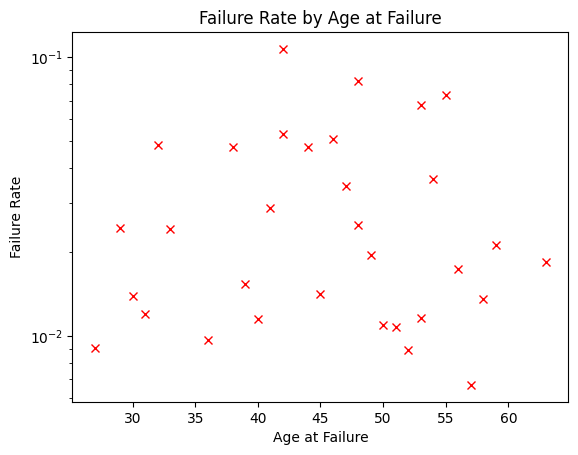

In [86]:
failure_rate_years = {}
for year in range(2010, 2019):
    failures_in_year = failure_train[failure_train.storing_melddatum.dt.year == year]
    failures_count_age_diameter = pd.DataFrame(failures_in_year.groupby(['age_at_failure', 'Diameter_group'])['storing_materiaal'].count()).reset_index()
    failures_count_age_diameter.rename(columns={'storing_materiaal': 'failure_count'}, inplace=True)
    
    pipe_train['age_in_year'] = year - pipe_train.Aanlegjaar.dt.year
    pipes_sum_length_age_diameter = pd.DataFrame(pipe_train.groupby(['age_in_year', 'Diameter_group'])['Lengte'].sum() / 1000).reset_index()
    failure_overview = pd.merge(failures_count_age_diameter, pipes_sum_length_age_diameter, left_on=['age_at_failure', 'Diameter_group'], right_on=['age_in_year', 'Diameter_group'], how='left')
    failure_overview.drop(['age_in_year'], axis=1, inplace=True)
    failure_overview['failure_rate_age'] = failure_overview['failure_count'] / failure_overview['Lengte']
    failure_rate_years[year] = failure_overview
plt.plot(failure_overview.age_at_failure, failure_overview.failure_rate_age, 'rx')
plt.yscale('log')
plt.xlabel('Age at Failure')
plt.ylabel('Failure Rate')
plt.title('Failure Rate by Age at Failure')
plt.show()

In [69]:
failure_overview.head(5)

,age_at_failure,Diameter_group,failure_count,Lengte,failure_rate_age
0,22.0,0 - 160,2,71.662315,0.027909
1,22.0,160 - 300,1,23.486603,0.042577
2,25.0,0 - 160,2,41.426505,0.048278
3,27.0,0 - 160,1,32.227962,0.031029
4,28.0,0 - 160,3,103.292802,0.029044


In [49]:
pipes_sum_length_age_diameter.head(5)

Lengte
age_in_year Diameter_group          
11          0 - 160         1.106446
16          0 - 160         0.006210
17          0 - 160         0.229768
            160 - 300       0.115500
18          0 - 160         1.510660

In [50]:
failures_count_age_diameter.head(5)

,age_at_failure,Diameter_group,storing_materiaal
0,22.0,0 - 160,2
1,22.0,160 - 300,1
2,25.0,0 - 160,2
3,27.0,0 - 160,1
4,28.0,0 - 160,3
